# Predicting Temperature and Humidity Using a Dense Neural Network

The temperature and humidy data look quite different from each other. 

In this exercise you can experiment by adjusting the frequency, amount of training data, and feature to learn which parameters give you the best scoring models.

In [35]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from keras.layers import LSTM

from scripts.data import deutsches_wetterdienst
from scripts.grid import grid_search

## The Data

Deutsches Wetterdienst data set contains temperature and humidity readings in Braunschweig Germany  during the years Jan 1951- Dec 2017. A subset of from 2013 - 2017 is loaded using the deutsches_wetterdienst() script.

The temperature and humidy data look quite different from eaach other.

In [36]:
df = deutsches_wetterdienst('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt', start=2010, end=2016)
df.head()

,Temp,Humi
datetime,,
2010-01-01 00:00:00,-1.8,89.0
2010-01-01 01:00:00,-1.8,88.0
2010-01-01 02:00:00,-1.8,89.0
2010-01-01 03:00:00,-1.8,88.0
2010-01-01 04:00:00,-2.1,91.0


## Experiment with the Model Parameters

### Change the Frequency

Here are a few frequency values that you can experiment with:

* YearEnd: 'A' calendar year end
* QuarterEnd: 'Q' calendar quarter end
* MonthEnd: 'M' calendar month end
* Week: 'W' one week, optionally anchored on a day of the week
* Day: 'D' one absolute day
* Hour: 'H' one hour

Learn more about datetime offsets in the pandas documentation:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html?highlight=datetime


### Change the Feature

You can choose from Temperature (Temp) or Humidity (Humi). 

Experiment with the parameters, and discover which ones give you the best performing Neural Network models.

In [37]:
# change the frequency
timestep = 'D'

# change the feature
feature = 'Humi'
df = df.resample(timestep).mean().ffill()
df.head()

,Temp,Humi
datetime,,
2010-01-01,-1.991667,87.375000
2010-01-02,-3.612500,92.000000
2010-01-03,-4.604167,91.500000
2010-01-04,-5.462500,84.375000
2010-01-05,-5.525000,82.166667


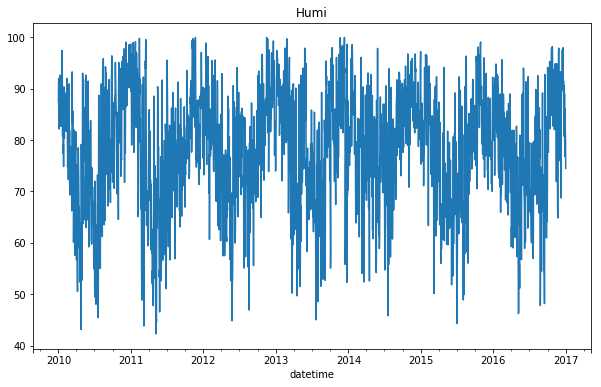

In [39]:
plt.figure(figsize=(10, 6))
plt.title(feature)
df[feature].plot();

## Training Data

Select the amount of training data you want to use by adjusting the "split_date".

The data before the split_date will be used to train and the data after the split_date will be used to for predicting the model performance.

In [40]:
split_date = pd.Timestamp('2016-01-01')

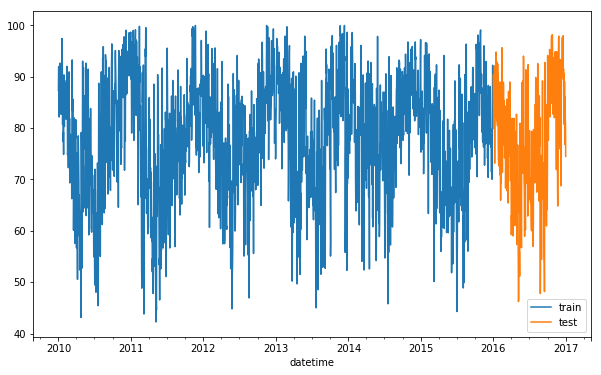

In [41]:
s =  df[feature]
train = s.loc[:split_date]
test = s.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [42]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [43]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## Dense Neural Network

In [44]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
2191/2191 [==============================] - 3s 1ms/step - loss: 0.1053
Epoch 2/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0814
Epoch 3/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0806
Epoch 4/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0803
Epoch 5/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0802
Epoch 6/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0802
Epoch 7/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0801
Epoch 8/100
2191/2191 [==============================] - 3s 1ms/step - loss: 0.0801
Epoch 9/100
2191/2191 [==============================] - 3s 1ms/step - loss: 0.0801
Epoch 10/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0801
Epoch 11/100
2191/2191 [==============================] - 2s 1ms/step - loss: 0.0801
Epoch 12/100
2191/2191 [==============================] - 3s 1ms/step - lo

Evaluate the performance of the model using R2

The best possible value for R2 is 1.0.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [45]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.475
The R2 score on the Test set is:	0.488
